## Sagnac Frequency - Backscatter Correction - RU shortterm

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [4]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# first test
config['tbeg'] = UTCDateTime("2024-05-22 00:00")
config['tend'] = UTCDateTime("2024-05-31 00:00")
flim1, flim2 = 447.726, 447.736



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [6]:
from functions.backscatter_correction import __backscatter_correction

In [7]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, bs.fj_fs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(447.726, 447.736)

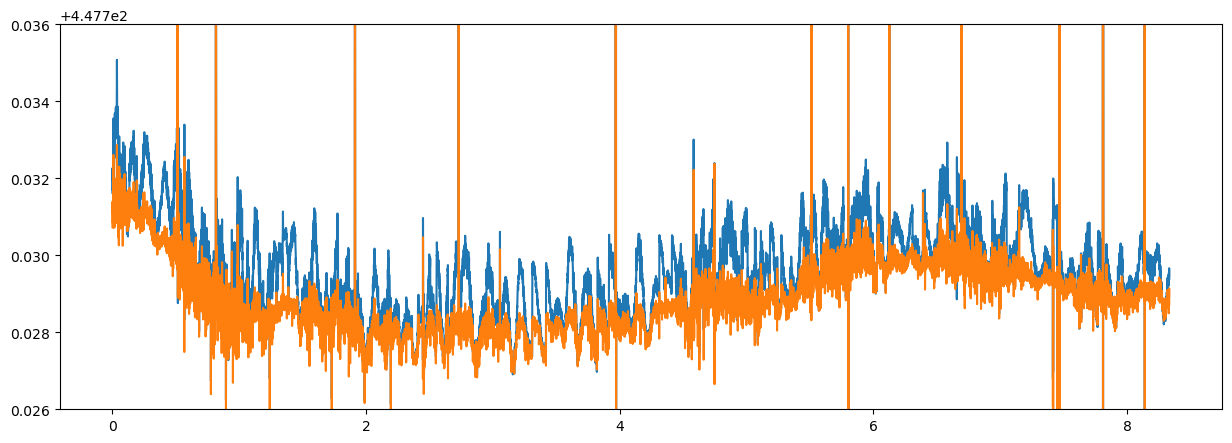

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [9]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [10]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [11]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [12]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=10)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=10)

### Apply special filter sections

In [13]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [14]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [15]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [16]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_1855469/1071450320.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


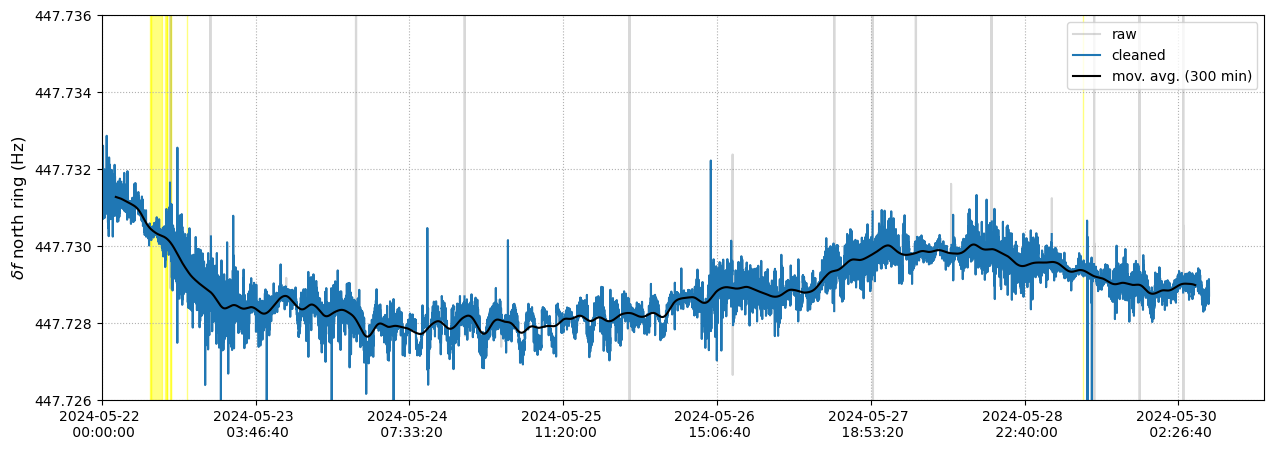

In [17]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_bs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")

    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [18]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

3 Trace(s) in Stream:
BW.WROMY.01.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples
BW.WROMY.05.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples
BW.WROMY.09.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples

### Load PROMY Data

In [19]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

3 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples
BW.PROMY.05.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples
BW.PROMY.09.LKI | 2024-05-22T00:00:00.000000Z - 2024-05-31T00:00:00.000000Z | 1.0 Hz, 777601 samples

### Load Rain Data

In [20]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [23]:
furt = __load_furt_stream(config['tbeg']-2*86400, config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

Specified end: 2024-05-30T23:59:59.000000Z 
Trace end:     2024-05-20T20:05:24.000000Z


In [24]:
rain = furt.select(channel="LAR")

# smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

### Load Tilt Data

In [26]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [27]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

  -> converted data of ROMYT


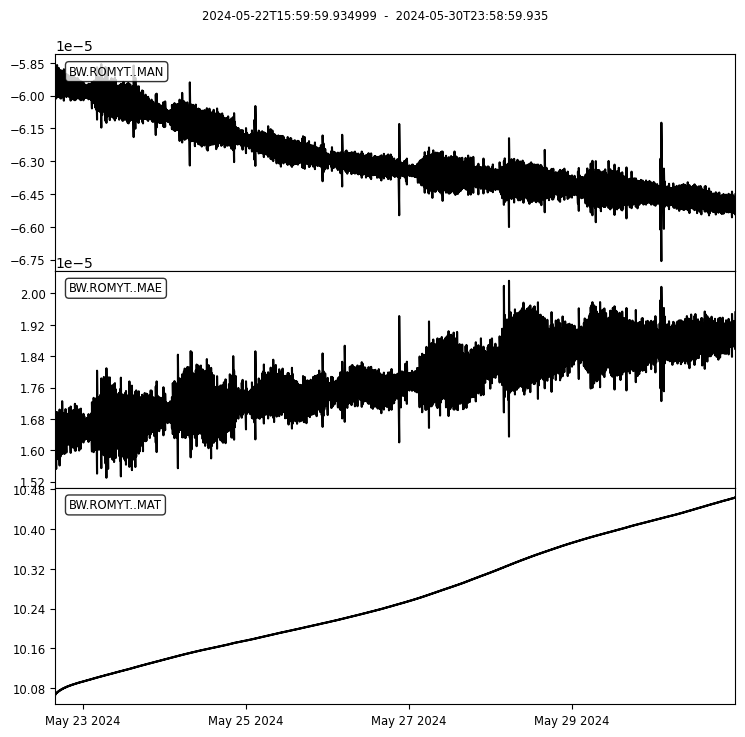

In [28]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

del tromy0

In [29]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
# # path_to_tilt = archive_path+"romy_archive/"

# bromy0 =  __read_sds(path_to_tilt, "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)


In [30]:
# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# bromy0 = __conversion_to_tilt(bromy0, confTilt['BROMY'])

# bromy0 = bromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

# # bromy0 = bromy0.filter("lowpass", freq=0.5, corners=4, zerophase=True)
# # bromy0 = bromy0.resample(1.0)

# bromy = bromy0.copy();

# bromy = bromy.merge(fill_value="interpolate");

# bromy.plot(equal_scale=False);

# del bromy0;

### Load Water Level Data

In [31]:
from functions.load_water_level import __load_water_level

In [32]:
try:
    pegel =  __load_water_level(config['tbeg'], config['tend'])

    ## remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

    pegel
except:
    print(" -> pegel not loaded")


 -> pegel not loaded


### Load Beam Wander Data

In [33]:
from functions.load_beam_wander_data import __load_beam_wander_data

In [34]:
bw = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+"ids/data07/")

2024-05-22
2024-05-23
2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28
2024-05-29
2024-05-30
2024-05-31


In [35]:
bw = bw[(bw.time > config['tbeg']) & (bw.time < config['tend'])]

bw.time_utc = np.array([UTCDateTime(_t) for _t in bw.time])

# conversion from pixel to mm
# config['conversion'] = {"XX":1.67e-3,
#                         "03":5.3e-3,
#                         "07":5.3e-3,
#                        }

bw['x_mm'] = bw.x*5.3e-3
bw['y_mm'] = bw.y*5.3e-3

bw['x_mm'] = __reduce(bw.x_mm, 100)
bw['y_mm'] = __reduce(bw.y_mm, 100)



/tmp/ipykernel_1855469/1752502659.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  bw.time_utc = np.array([UTCDateTime(_t) for _t in bw.time])


In [36]:
gc.collect()

9661

### Load Infrasound FFBI

In [1]:
ffbi = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])

if len(ffbi) != 2:
    ffbi.merge();

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")
ffbi = ffbi.remove_response(ffbi_inv, water_level=10)

ffbi += __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDO", config['tbeg'], config['tend'])
for tr in ffbi:
    if "O" in tr.stats.channel:
        tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

ffbi = ffbi.resample(1.0, no_filter=False)

ffbi.merge()

ffbi.plot(equal_scale=False);

NameError: name '__read_sds' is not defined

## Plotting

In [ ]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

In [ ]:
# bromyN_smooth = __reduce(bromy.select(channel="*N")[0].data, 100)
# bromyE_smooth = __reduce(bromy.select(channel="*E")[0].data, 100)

In [ ]:
tromyN_smooth = __smooth(__reduce(tromy.select(channel="*N")[0].data, 100), int(20*tromy.select(channel="*N")[0].stats.sampling_rate))
tromyE_smooth = __smooth(__reduce(tromy.select(channel="*E")[0].data, 100), int(20*tromy.select(channel="*E")[0].stats.sampling_rate))

In [ ]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    ref_date = bs.time1.iloc[0]

    # _____________________________________________________________________________________
    #
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")

    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    # _____________________________________________________________________________________
    #
    for tr in ws.select(channel="*T"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    # ax[1].set_ylim(10.5, 11)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
              __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

    ax11.set_ylabel("Temperature (°C)", fontsize=font, color=config['colors'][1])
    [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))



    # _____________________________________________________________________________________
    #
    try:
        ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=UTCDateTime(ref_date)),
                      __interpolate_nan(rain[0].data), color="tab:blue", alpha=0.6, label=f"rain", zorder=0)

    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation \n (mm/s)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_zorder(1)


    ax24 = ax[2].twinx()
    ax24.plot(rain_cumsum/max(rain_cumsum)*100, alpha=0.9, zorder=1, ls="--", color="darkblue")

    # ax24.axis('off')
    ax24.set_zorder(1)
    ax24.spines.right.set_position(("axes", 1.12))

    # ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    # [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]
    ax24.set_ylabel(f"Cum. Rain (%)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]


    # _____________________________________________________________________________________
    #
    ax[3].plot(tromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               tromyN_smooth[:-20]*1e6,
               label=f"T{tromy[0].stats.station} N-S (20 sec. avg.)", color="tab:orange")
    ax[3].plot(tromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               tromyE_smooth[:-20]*1e6,
               label=f"T{tromy[0].stats.station} E-W (20 sec. avg.)", color="tab:brown")

    # ax[3].plot(bromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyN_smooth[:-20]*1e6,
    #            label=f"T{bromy[0].stats.station} N-S (20 sec. avg.)", color="tab:red")
    # ax[3].plot(bromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyE_smooth[:-20]*1e6,
    #            label=f"T{bromy[0].stats.station} E-W (20 sec. avg.)", color="tab:blue")

    ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[3].set_ylim(-5, 5)

    # _____________________________________________________________________________________
    #
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi_bdf_smooth1,
               label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (1 min. avg.)",
               color="tab:red"
              )
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi_bdf_smooth2,
               color="white", ls="-", lw=1,
              )

    ax[4].set_ylabel("Differential \n Pressure (Pa)", fontsize=font)
    # ax[4].set_ylim(-, 6)

    ax41 = ax[4].twinx()
    ax41.plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
              ffbi.select(channel="*O")[0].data*100,
              color="darkred"
              )
    ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax41.yaxis.get_ticklabels()]

#     # _____________________________________________________________________________________
#     #
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.x_mm*1e3,
                  label=f"in-plane",
                  color="tab:pink",
                  zorder=2,
                  s=5,
              )
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.y_mm*1e3,
                  label=f"out-of-plane",
                  color="purple",
                  zorder=2,
                  s=5,
              )

    ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)
    ax[5].set_ylim(-50, 50)


    # _____________________________________________________________________________________
    #
    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)


    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=1, ncol=1)
    ax11.legend(loc=4, ncol=1)
    ax[3].legend(loc=3, ncol=1)
    ax[4].legend(loc=2, ncol=1)
    ax[5].legend(loc=2, ncol=1)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RV_shortterm_environmentals_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


## Define Dataframe

In [ ]:

df = DataFrame()

reftime = bs.time1.iloc[0]

df['time'] = bs.time_sec

df['fj_bs'] = __reduce(bs.fj_bs_inter, 10)

ps3_data = __reduce(__interpolate_nan(ps.select(location="03")[0].data), 100)
df['ps3'] = np.interp(df.time, ps.select(location="03")[0].times(reftime=reftime), ps3_data)

ps1_data = __reduce(__interpolate_nan(__smooth(ps.select(location="01")[0].data, 1800)), 100)
df['ps1'] = np.interp(df.time, ps.select(location="01")[0].times(reftime=reftime), ps1_data)

ps5_data = __reduce(__interpolate_nan(__smooth(ps.select(location="05")[0].data, 1800)), 100)
df['ps5'] = np.interp(df.time, ps.select(location="05")[0].times(reftime=reftime), ps5_data)

ps9_data = __reduce(__interpolate_nan(__smooth(ps.select(location="09")[0].data, 1800)), 100)
df['ps9'] = np.interp(df.time, ps.select(location="09")[0].times(reftime=reftime), ps9_data)

bdo_data = __reduce(ffbi.select(channel="BDO")[0].data, 100)
df['bdo'] = np.interp(df.time, ffbi.select(channel="BDO")[0].times(reftime=reftime), bdo_data)

bdf_data = __reduce(__interpolate_nan(__smooth(ffbi.select(channel="BDF")[0].data, 600)), 100)
df['bdf'] = np.interp(df.time, ffbi.select(channel="BDF")[0].times(reftime=reftime), bdf_data)

man_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAN")[0].data, 5*60)), 100)
df['man'] = np.interp(df.time, tromy.select(channel="MAN")[0].times(reftime=reftime), man_data)

mae_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAE")[0].data, 5*60)),100)
df['mae'] = np.interp(df.time, tromy.select(channel="MAE")[0].times(reftime=reftime), mae_data)

peg_data = __reduce(__interpolate_nan(__smooth(pegel.pegel, 20)), 100)
df['peg'] = np.interp(df.time, pegel.times_utc - bs.time1.iloc[0], peg_data)

bwx = bw.x_mm
bwx = np.where((abs(np.diff(bwx, prepend=0)) > 0.001), np.nan, bwx)
bwx = np.where((abs(bwx) > 0.1), np.nan, bwx)

df['bwx'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwx), 10)))

bwy = bw.y_mm
bwy = np.where((abs(np.diff(bwy, prepend=0)) > 0.001), np.nan, bwy)
bwy = np.where((abs(bwy) > 0.1), np.nan, bwy)

df['bwy'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwy), 10)))


In [ ]:
df.to_pickle(config['path_to_out_data']+"multi_regression_df2.pkl")

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
# specify target column
target = 'fj_bs'

# create list for features
features = list(df.columns)

# remove time and target
features.remove(target)
features.remove("time")

# features = ['ps1', 'ps5', 'ps9', 'ps3', 'bdo', 'man', 'mae', 'pegel', 'bwx', 'bwy']

# define x data
X = df[features].values.reshape(-1, len(features))

# define y data
y = df[target].values

# multi linear regression
# ols = linear_model.LinearRegression()
# model = ols.fit(X, y)
# model.coef_
# model.intercept_
# print(model.score(X, y))

# model = RANSACRegressor(random_state=1).fit(X, y)
# print(model.score(X, y))

model = TheilSenRegressor().fit(X, y)
model.coef_
model.intercept_
print(model.score(X, y))


In [ ]:
f = features.copy()
df.plot(x="time", y=f.append("fj_bs"), subplots=True, figsize=(15,10))

In [ ]:
mod = f"df = "
# for i, c in enumerate(model.coef_):
#     if c >= 0:
#         mod += f" + {abs(c):.2f} *a{i}"
#     elif c < 0:
#         mod += f" - {abs(c):.2f} *a{i}"

# mod += f" + {model.intercept_:.3f}"

# mod

## Predict Model

In [ ]:
model_predict = []

for o, row in df[features].iterrows():

    x_pred = []
    for feat in features:
        x_pred.append(row[feat])
    x_pred = np.array(x_pred)
    x_pred = x_pred.reshape(-1, len(features))

    model_predict.append(model.predict(x_pred))

In [ ]:
def __makeplot():

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df.time*tscale, df.fj_bs, color="k", label="observed")
    ax.plot(df.time*tscale, model_predict, color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=1, fontsize=font-2)

    ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={model.score(X, y):.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df.time*tscale), max(df.time*tscale))

    ax.set_title(mod)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_model_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df0 = df.iloc[:, 1:]

corr = df0.corr(method='pearson')

# mask upper triangle
corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)



# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap = plt.get_cmap("coolwarm", 9)

# Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

plt.colorbar(im, extend="both")

labels = list(corr.columns)
ax = plt.gca()
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_yticklabels(labels)


fig.suptitle('Pearson Correlation Matrix', fontsize=15)

fig.tight_layout();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_ccmatrix_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

######################################## Data preparation #########################################

X = df[['mae', 'man']].values.reshape(-1, 2)
Y = df['fj_bs']

######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(6, 24, 30)      # range of porosity values
y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Porosity (%)', fontsize=12)
    ax.set_ylabel('VR', fontsize=12)
    ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout();

